## Лабораторная работа 5: Обучение и тестирование модели

In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from PIL import Image


In [2]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms



создание списка путей изображений из заданного csv-файла

In [3]:
dframe = pd.read_csv(
    "D:\Lab on python\Lab_1_var_4\Lab2\csv_files\datasets.csv", delimiter=",", names=["Absolute path", "Relative path", "Class"]
)
img_list=dframe["Absolute path"].tolist()
random.shuffle(img_list)
print(img_list[:5])


['D:\\Lab on python\\Lab_1_var_4\\dataset\\rose\\0481.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0959.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\rose\\0765.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0849.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\rose\\0185.jpg']


Способ получение метки класс

In [4]:
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['rose', 'tulip', 'rose', 'tulip', 'rose']


Разделение списка изображение на тренировочный, тестовый и валидационный (80:10:10)

In [5]:
train_list = img_list[0 : int(len(img_list) * 0.8)]
test_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
val_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))]
print(len(train_list ))
print(len(test_list))
print(len(val_list))



1608
201
202


Проверкк картинок

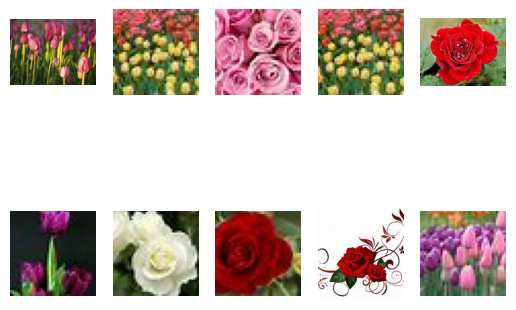

In [9]:
random_idx = np.random.randint(1,len(img_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')


plt.show()

класс dataset, который будет хранить загруженные и преобразованные изображения и метки классов 0 - розы, 1 - тюльпаны

In [104]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_label=[]
        for i in range(len(self.file_list)):
            img_label.append(os.path.basename(os.path.dirname(self.file_list[i])))
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[idx]
        if label == 'rose':
            label=0
        elif label == 'tulip':
            label=1
        return img_transformed,label  

пайплайн предобработки данных и формированя набора даных, который будет участвовать в обучении

In [105]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(train_list, transform=fixed_transforms)
test_data = dataset(test_list, transform=fixed_transforms)
val_data = dataset(val_list, transform=fixed_transforms)

In [106]:
print(len(train_data))
train_data[0][0].shape


1608


torch.Size([3, 224, 224])

класс построения сверточной модели:
1. 3 слоя свертки и 2 полностью связанных слоя
2. пакетная нормализация для ограничения переобучения

In [107]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [108]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

функция для создания графиков

In [109]:
def show_results(epochs, acc, loss):
    plt.figure(figsize=(15, 5))
    plt.plot(range(epochs), acc, color="green")
    plt.legend(["Accuracy"])
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(range(epochs), loss, color="blue")
    plt.legend(["Loss"])
    plt.show() 
    
    print(acc, '\n',loss)

цикл обучения

In [110]:
def train_loop(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    show_results(epochs,accuracy_values, loss_values)
    show_results(epochs, val_accuracy_values, val_loss_values)

9 запусков с разными batch_size и lear и графиками для тренировочной и валидационной выборки

Epoch : 1, train accuracy : 0.9702940583229065, train loss : 0.068520188331604
Epoch : 1, val_accuracy : 0.9666666984558105, val_loss : 0.11932840943336487
Epoch : 2, train accuracy : 0.9788234233856201, train loss : 0.046135034412145615
Epoch : 2, val_accuracy : 0.9666666984558105, val_loss : 0.10770702362060547
Epoch : 3, train accuracy : 0.9852940440177917, train loss : 0.03892059624195099
Epoch : 3, val_accuracy : 0.9733333587646484, val_loss : 0.08659660071134567
Epoch : 4, train accuracy : 0.9847058057785034, train loss : 0.04694237932562828
Epoch : 4, val_accuracy : 0.9766666889190674, val_loss : 0.07696069031953812
Epoch : 5, train accuracy : 0.9882352352142334, train loss : 0.030180515721440315
Epoch : 5, val_accuracy : 0.9666666984558105, val_loss : 0.12319255620241165
Epoch : 6, train accuracy : 0.9835293292999268, train loss : 0.040151290595531464
Epoch : 6, val_accuracy : 0.9733333587646484, val_loss : 0.0858636125922203
Epoch : 7, train accuracy : 0.9864705204963684, trai

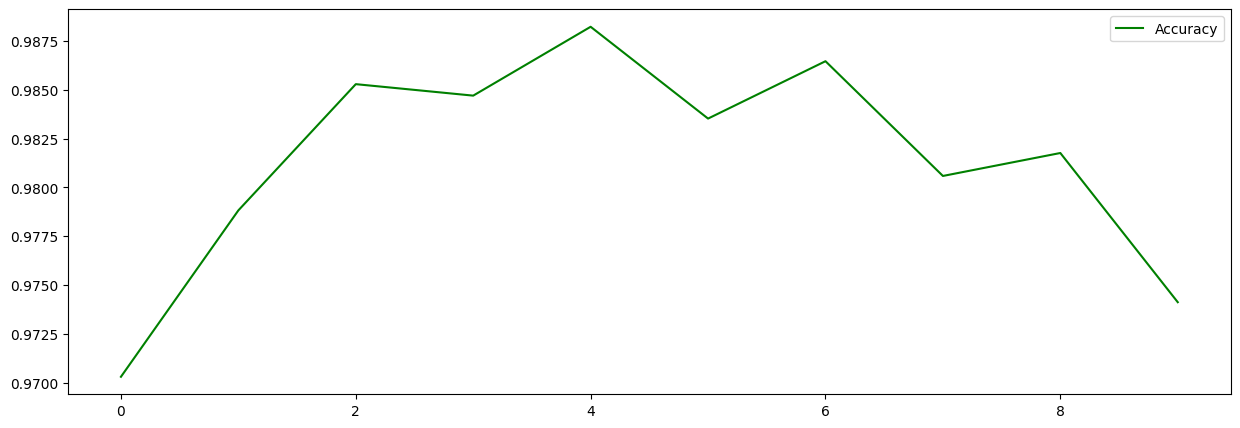

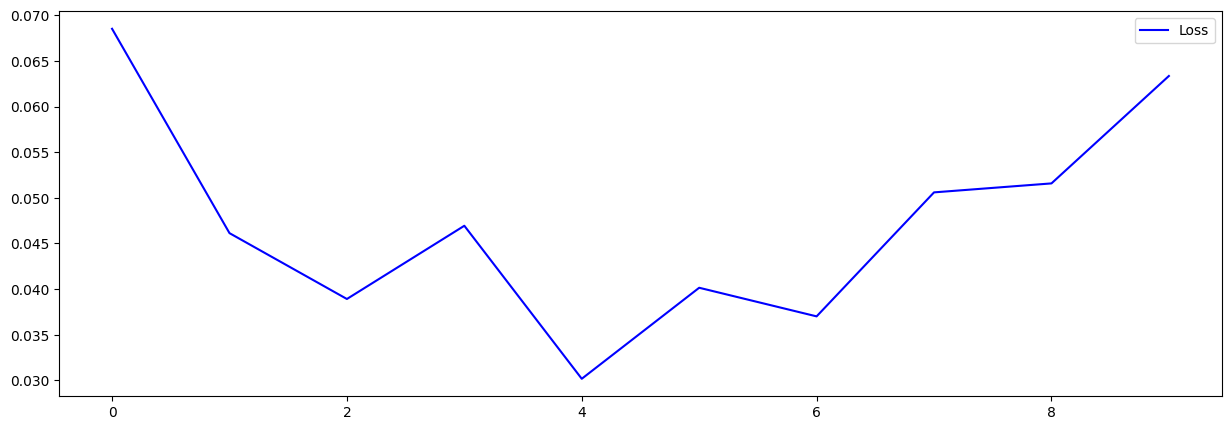

[0.9702940583229065, 0.9788234233856201, 0.9852940440177917, 0.9847058057785034, 0.9882352352142334, 0.9835293292999268, 0.9864705204963684, 0.9805881381034851, 0.9817646145820618, 0.9741175770759583] 
 [0.068520188331604, 0.046135034412145615, 0.03892059624195099, 0.04694237932562828, 0.030180515721440315, 0.040151290595531464, 0.037015970796346664, 0.0506000854074955, 0.051581840962171555, 0.0633494183421135]


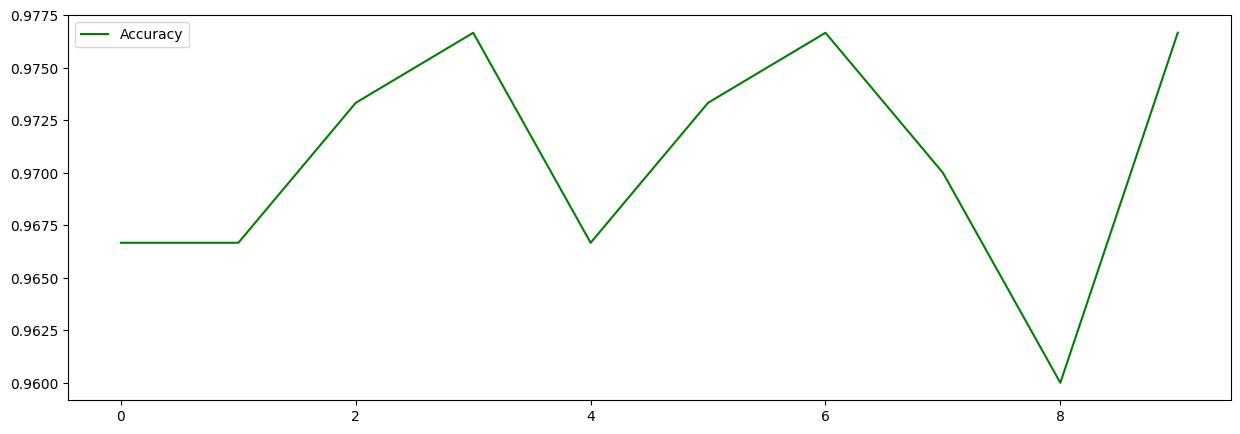

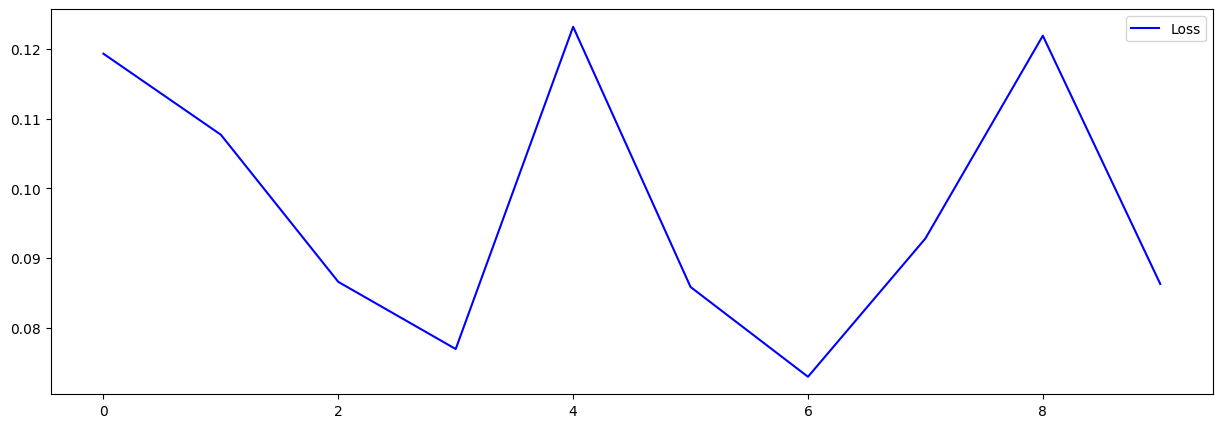

[0.9666666984558105, 0.9666666984558105, 0.9733333587646484, 0.9766666889190674, 0.9666666984558105, 0.9733333587646484, 0.9766666889190674, 0.9700000286102295, 0.9600000381469727, 0.9766666889190674] 
 [0.11932840943336487, 0.10770702362060547, 0.08659660071134567, 0.07696069031953812, 0.12319255620241165, 0.0858636125922203, 0.07297923415899277, 0.09282110631465912, 0.12191075831651688, 0.08629973232746124]


In [135]:
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.9472222328186035, train loss : 0.15681129693984985
Epoch : 1, val_accuracy : 0.7300000190734863, val_loss : 0.40967532992362976
Epoch : 2, train accuracy : 0.9511110782623291, train loss : 0.14618150889873505
Epoch : 2, val_accuracy : 0.7150000333786011, val_loss : 0.3139287233352661
Epoch : 3, train accuracy : 0.9555554986000061, train loss : 0.13776151835918427
Epoch : 3, val_accuracy : 0.4675000011920929, val_loss : 0.8718892335891724
Epoch : 4, train accuracy : 0.9522222280502319, train loss : 0.12423031032085419
Epoch : 4, val_accuracy : 0.9700000286102295, val_loss : 0.2524340748786926
Epoch : 5, train accuracy : 0.945555567741394, train loss : 0.12784352898597717
Epoch : 5, val_accuracy : 0.9700000286102295, val_loss : 0.22302868962287903
Epoch : 6, train accuracy : 0.9477778077125549, train loss : 0.13776256144046783
Epoch : 6, val_accuracy : 0.9724999666213989, val_loss : 0.1686248481273651
Epoch : 7, train accuracy : 0.9288888573646545, train los

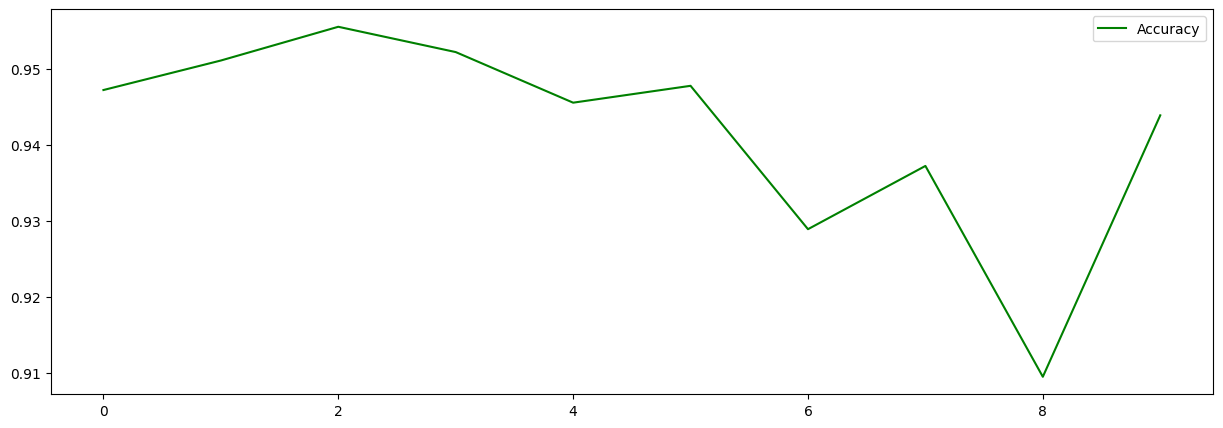

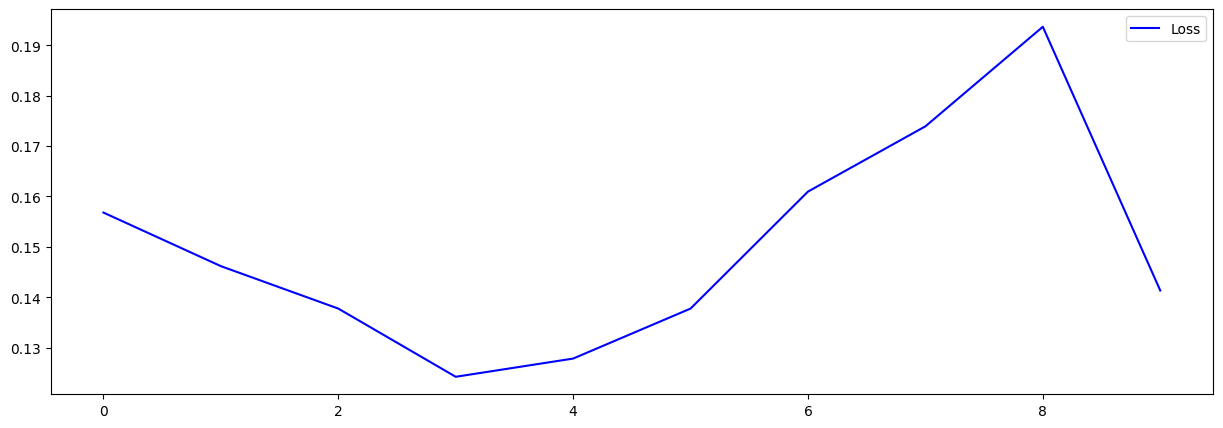

[0.9472222328186035, 0.9511110782623291, 0.9555554986000061, 0.9522222280502319, 0.945555567741394, 0.9477778077125549, 0.9288888573646545, 0.9372221827507019, 0.9094444513320923, 0.9438888430595398] 
 [0.15681129693984985, 0.14618150889873505, 0.13776151835918427, 0.12423031032085419, 0.12784352898597717, 0.13776256144046783, 0.1609712690114975, 0.17392095923423767, 0.19367243349552155, 0.14134608209133148]


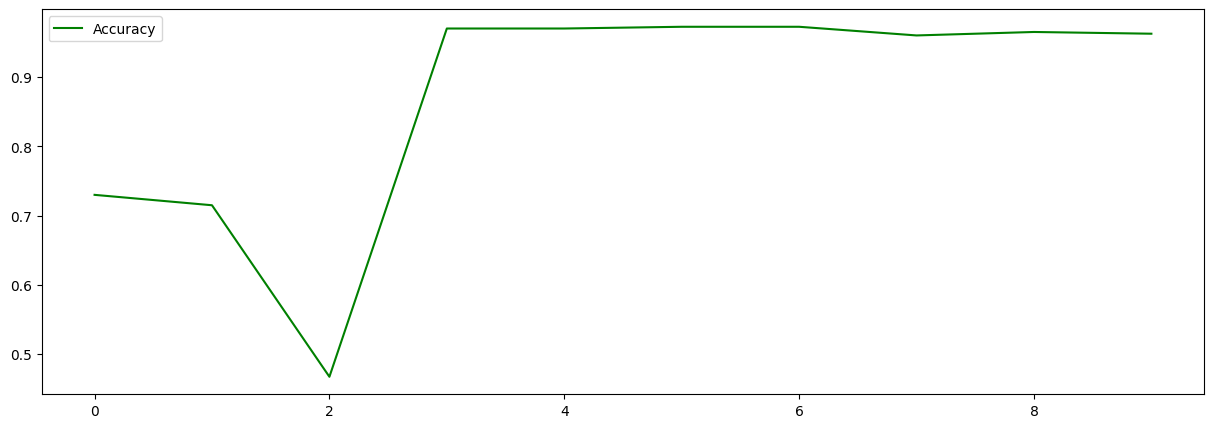

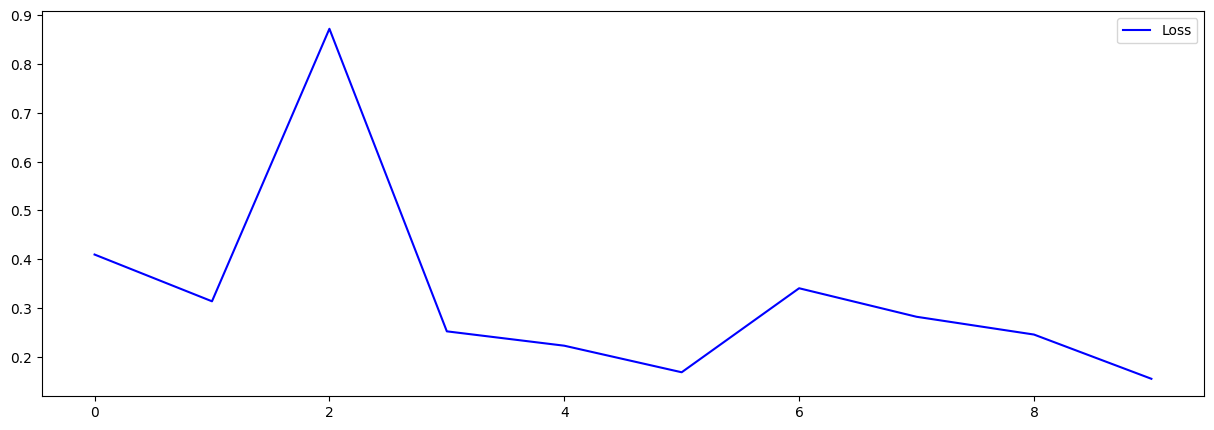

[0.7300000190734863, 0.7150000333786011, 0.4675000011920929, 0.9700000286102295, 0.9700000286102295, 0.9724999666213989, 0.9724999666213989, 0.9600000381469727, 0.9650000333786011, 0.9624999761581421] 
 [0.40967532992362976, 0.3139287233352661, 0.8718892335891724, 0.2524340748786926, 0.22302868962287903, 0.1686248481273651, 0.3406546711921692, 0.2822660803794861, 0.24586521089076996, 0.1553071290254593]


In [112]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.9538271427154541, train loss : 0.12125712633132935
Epoch : 1, val_accuracy : 0.9504950642585754, val_loss : 0.17633047699928284
Epoch : 2, train accuracy : 0.9538888931274414, train loss : 0.1280898153781891
Epoch : 2, val_accuracy : 0.9405940771102905, val_loss : 0.16837315261363983
Epoch : 3, train accuracy : 0.9606173038482666, train loss : 0.1048518493771553
Epoch : 3, val_accuracy : 0.9554455280303955, val_loss : 0.13753169775009155
Epoch : 4, train accuracy : 0.9638272523880005, train loss : 0.09582208096981049
Epoch : 4, val_accuracy : 0.9504950642585754, val_loss : 0.12069687992334366
Epoch : 5, train accuracy : 0.9735802412033081, train loss : 0.09973397850990295
Epoch : 5, val_accuracy : 0.9653465151786804, val_loss : 0.13532283902168274
Epoch : 6, train accuracy : 0.9593827128410339, train loss : 0.10210481286048889
Epoch : 6, val_accuracy : 0.9702970385551453, val_loss : 0.13226652145385742
Epoch : 7, train accuracy : 0.9677160978317261, train 

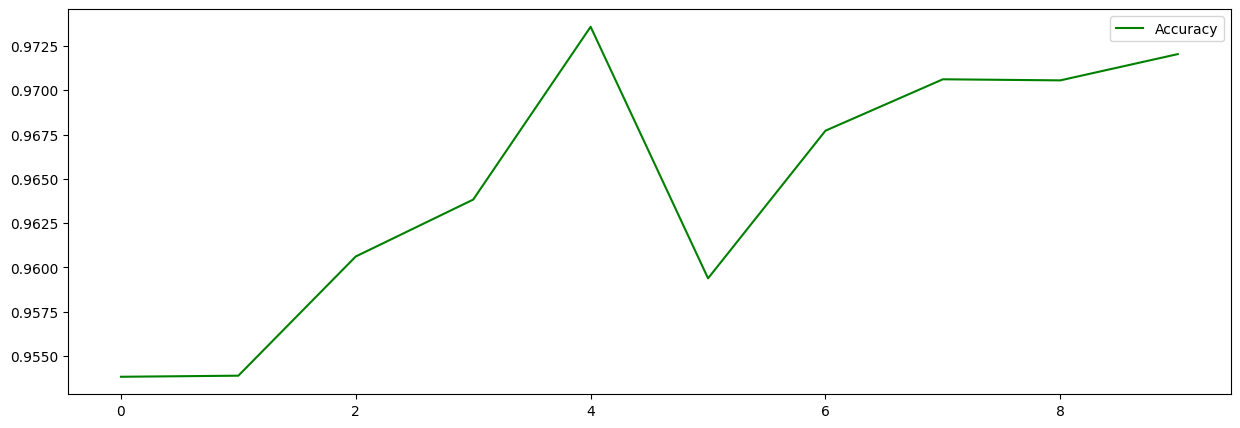

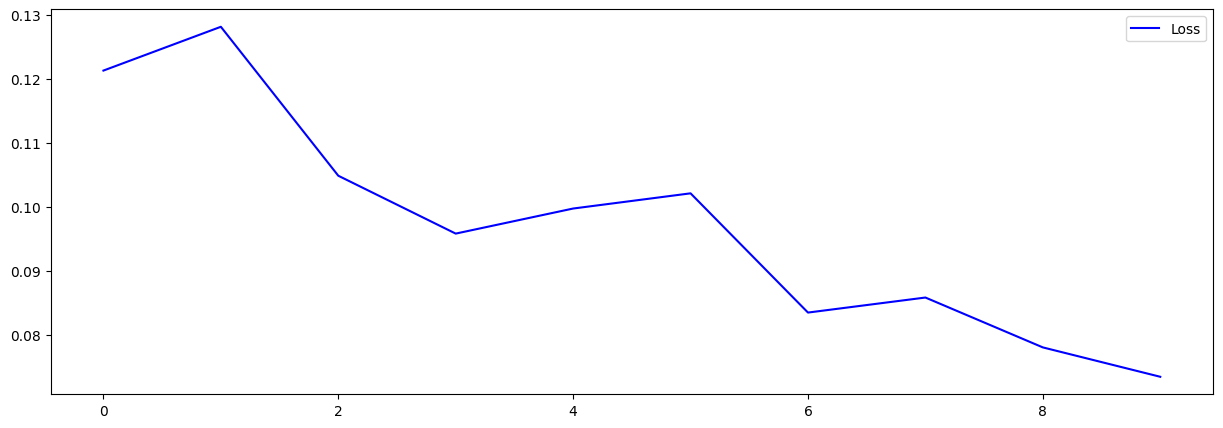

[0.9538271427154541, 0.9538888931274414, 0.9606173038482666, 0.9638272523880005, 0.9735802412033081, 0.9593827128410339, 0.9677160978317261, 0.9706172347068787, 0.9705555438995361, 0.9720370173454285] 
 [0.12125712633132935, 0.1280898153781891, 0.1048518493771553, 0.09582208096981049, 0.09973397850990295, 0.10210481286048889, 0.08350276201963425, 0.08584833145141602, 0.0780687928199768, 0.07348517328500748]


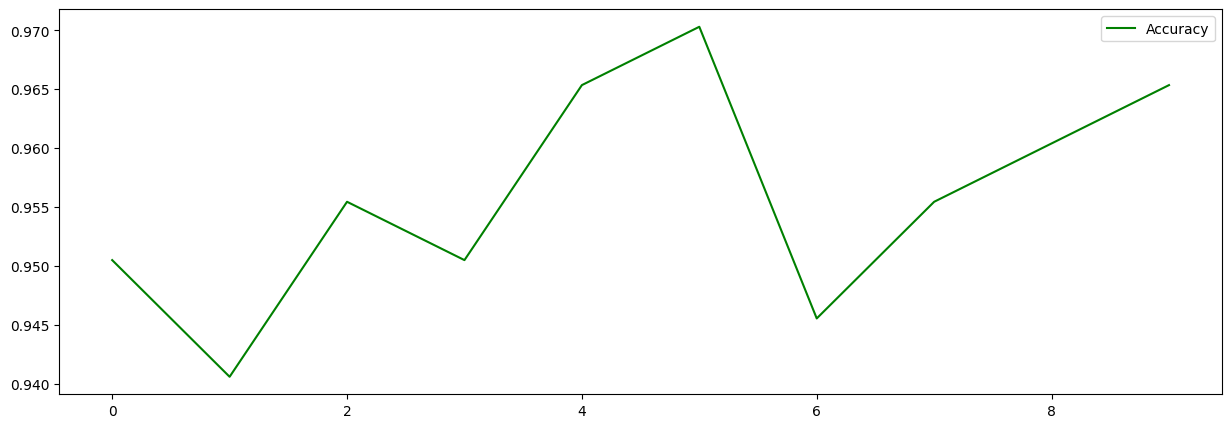

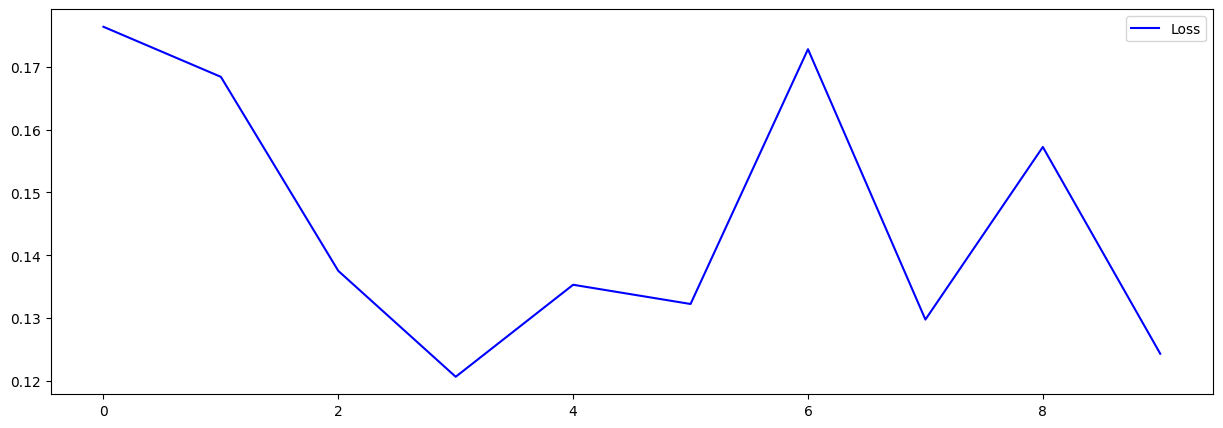

[0.9504950642585754, 0.9405940771102905, 0.9554455280303955, 0.9504950642585754, 0.9653465151786804, 0.9702970385551453, 0.9455445408821106, 0.9554455280303955, 0.9603960514068604, 0.9653465151786804] 
 [0.17633047699928284, 0.16837315261363983, 0.13753169775009155, 0.12069687992334366, 0.13532283902168274, 0.13226652145385742, 0.17276673018932343, 0.1297907680273056, 0.15722517669200897, 0.1243603378534317]


In [113]:
train_loop(10, 300, 0.001)

Epoch : 1, train accuracy : 0.8600000739097595, train loss : 0.45894554257392883
Epoch : 1, val_accuracy : 0.7633333206176758, val_loss : 0.38822662830352783
Epoch : 2, train accuracy : 0.9091176390647888, train loss : 0.22423164546489716
Epoch : 2, val_accuracy : 0.7800000309944153, val_loss : 0.2685019373893738
Epoch : 3, train accuracy : 0.9370588064193726, train loss : 0.17491303384304047
Epoch : 3, val_accuracy : 0.9300000667572021, val_loss : 0.234945148229599
Epoch : 4, train accuracy : 0.9247058033943176, train loss : 0.169770747423172
Epoch : 4, val_accuracy : 0.9566667079925537, val_loss : 0.16468729078769684
Epoch : 5, train accuracy : 0.9441174864768982, train loss : 0.15507206320762634
Epoch : 5, val_accuracy : 0.7766667008399963, val_loss : 0.5265063047409058
Epoch : 6, train accuracy : 0.9194117188453674, train loss : 0.21365252137184143
Epoch : 6, val_accuracy : 0.9566667079925537, val_loss : 0.14719004929065704
Epoch : 7, train accuracy : 0.8905882239341736, train loss

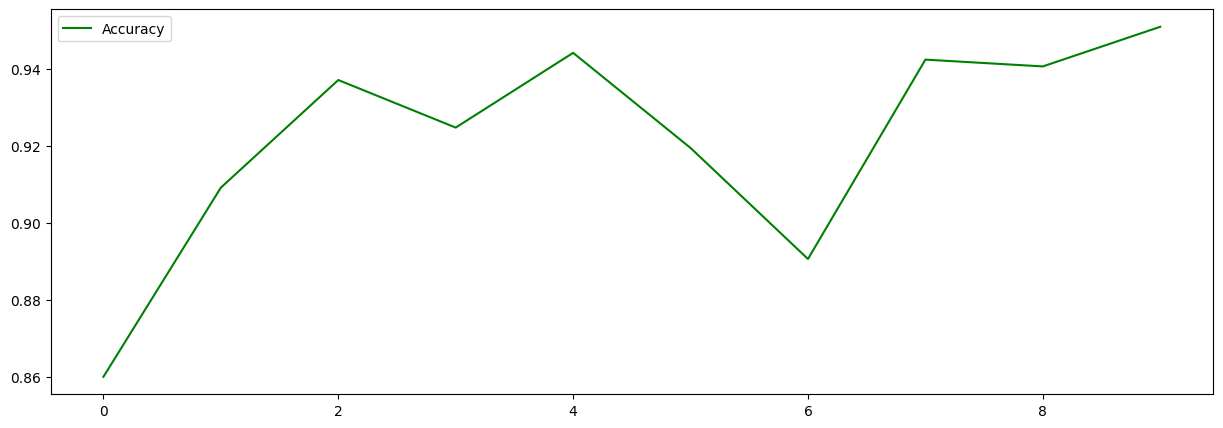

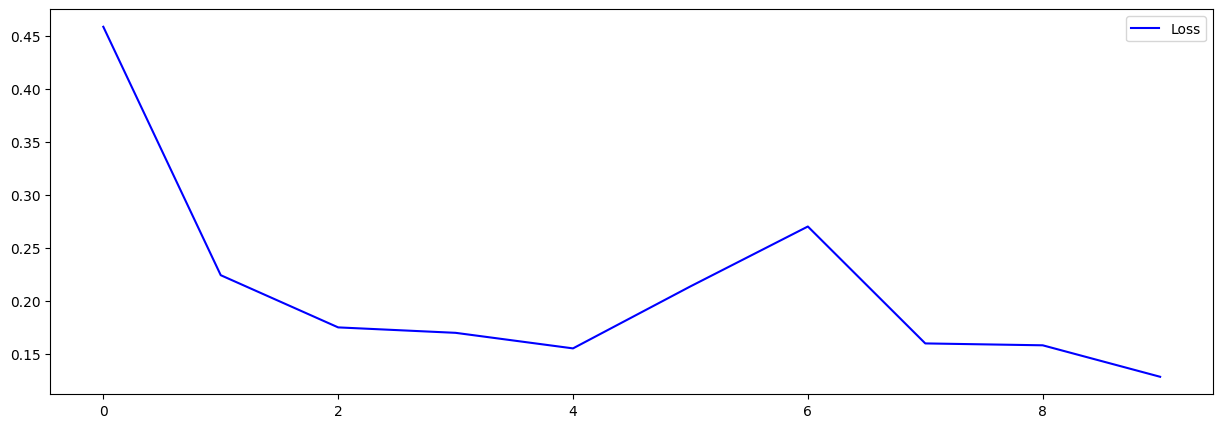

[0.8600000739097595, 0.9091176390647888, 0.9370588064193726, 0.9247058033943176, 0.9441174864768982, 0.9194117188453674, 0.8905882239341736, 0.942352831363678, 0.9405881762504578, 0.9508822560310364] 
 [0.45894554257392883, 0.22423164546489716, 0.17491303384304047, 0.169770747423172, 0.15507206320762634, 0.21365252137184143, 0.27022939920425415, 0.15976572036743164, 0.1579868197441101, 0.1282479465007782]


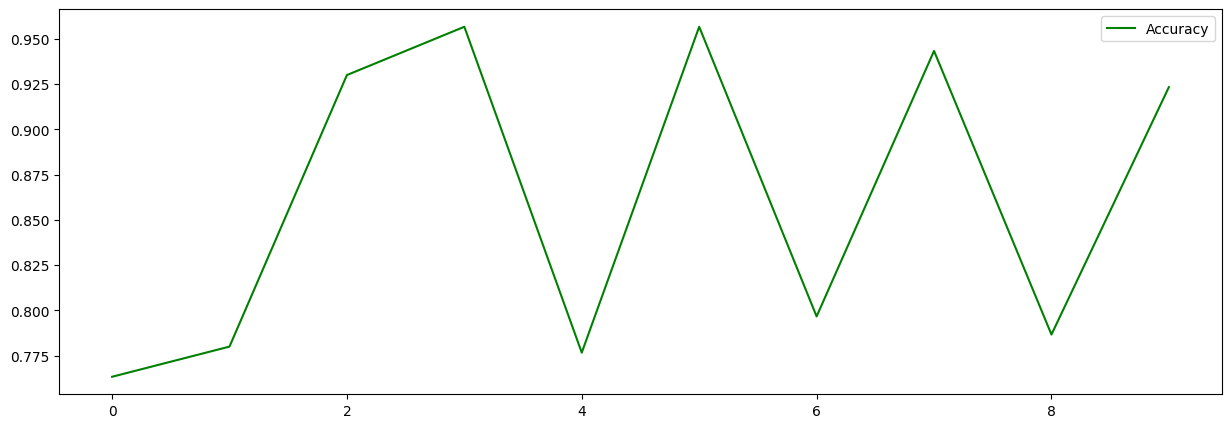

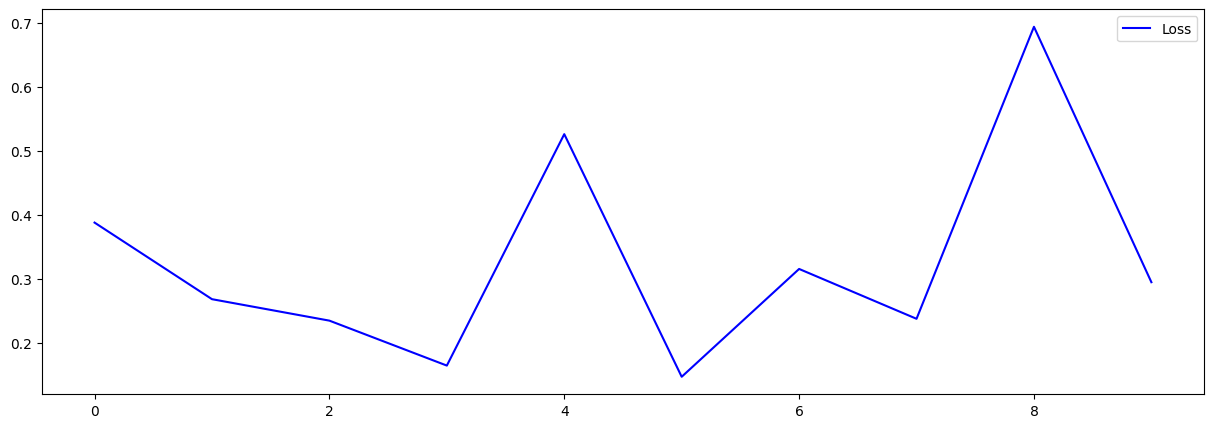

[0.7633333206176758, 0.7800000309944153, 0.9300000667572021, 0.9566667079925537, 0.7766667008399963, 0.9566667079925537, 0.79666668176651, 0.9433333873748779, 0.7866666913032532, 0.9233334064483643] 
 [0.38822662830352783, 0.2685019373893738, 0.234945148229599, 0.16468729078769684, 0.5265063047409058, 0.14719004929065704, 0.31576094031333923, 0.2378404438495636, 0.694369375705719, 0.29503655433654785]


In [114]:
train_loop(10, 100, 0.005)

Epoch : 1, train accuracy : 0.9466666579246521, train loss : 0.15352538228034973
Epoch : 1, val_accuracy : 0.4699999988079071, val_loss : 1.21371328830719
Epoch : 2, train accuracy : 0.9283333420753479, train loss : 0.19179688394069672
Epoch : 2, val_accuracy : 0.9624999761581421, val_loss : 0.11992071568965912
Epoch : 3, train accuracy : 0.9372222423553467, train loss : 0.14741671085357666
Epoch : 3, val_accuracy : 0.9724999666213989, val_loss : 0.0919932872056961
Epoch : 4, train accuracy : 0.9461110830307007, train loss : 0.1463203728199005
Epoch : 4, val_accuracy : 0.9624999761581421, val_loss : 0.29112303256988525
Epoch : 5, train accuracy : 0.9449999928474426, train loss : 0.16281116008758545
Epoch : 5, val_accuracy : 0.9624999761581421, val_loss : 0.17348849773406982
Epoch : 6, train accuracy : 0.925000011920929, train loss : 0.15081165730953217
Epoch : 6, val_accuracy : 0.7124999761581421, val_loss : 0.8096687197685242
Epoch : 7, train accuracy : 0.926111102104187, train loss :

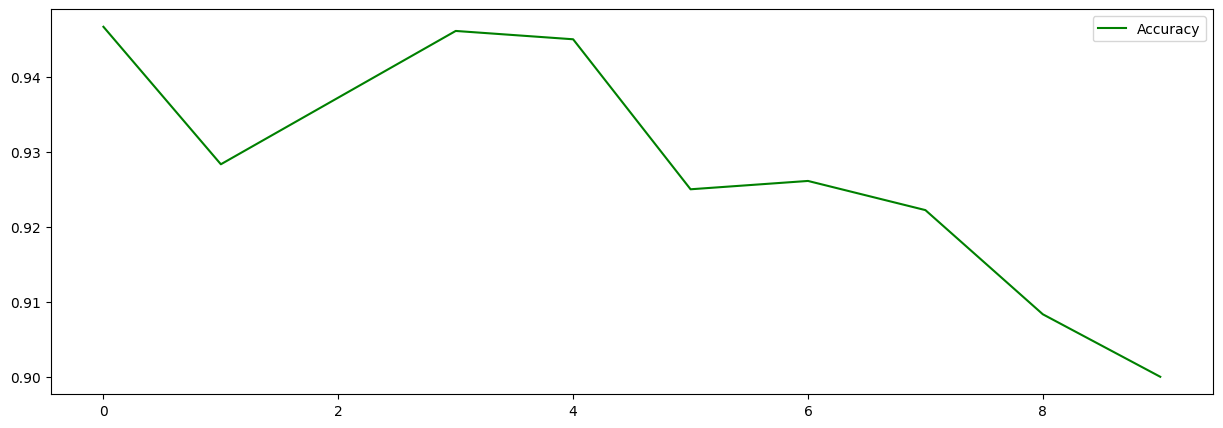

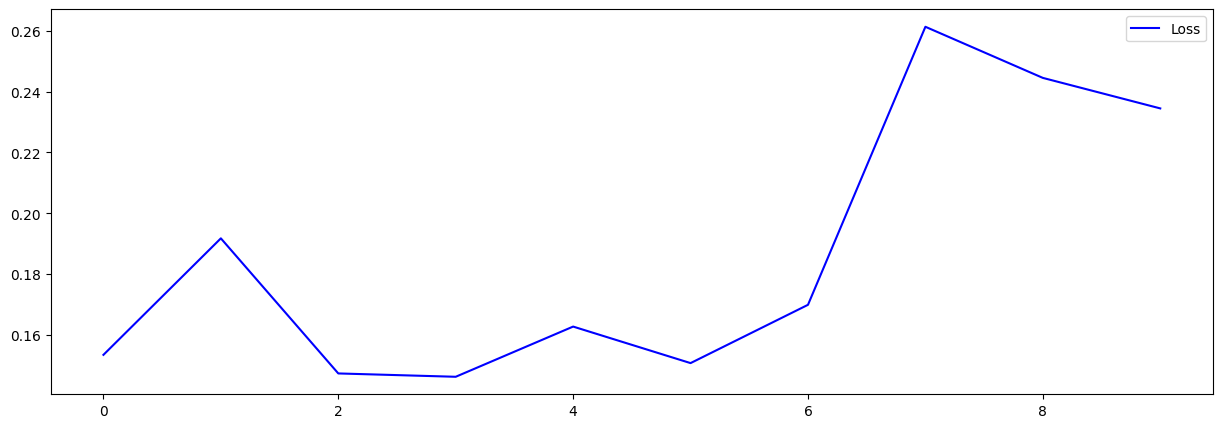

[0.9466666579246521, 0.9283333420753479, 0.9372222423553467, 0.9461110830307007, 0.9449999928474426, 0.925000011920929, 0.926111102104187, 0.9222221970558167, 0.9083333015441895, 0.8999999761581421] 
 [0.15352538228034973, 0.19179688394069672, 0.14741671085357666, 0.1463203728199005, 0.16281116008758545, 0.15081165730953217, 0.16996176540851593, 0.26129674911499023, 0.2445061355829239, 0.2344810962677002]


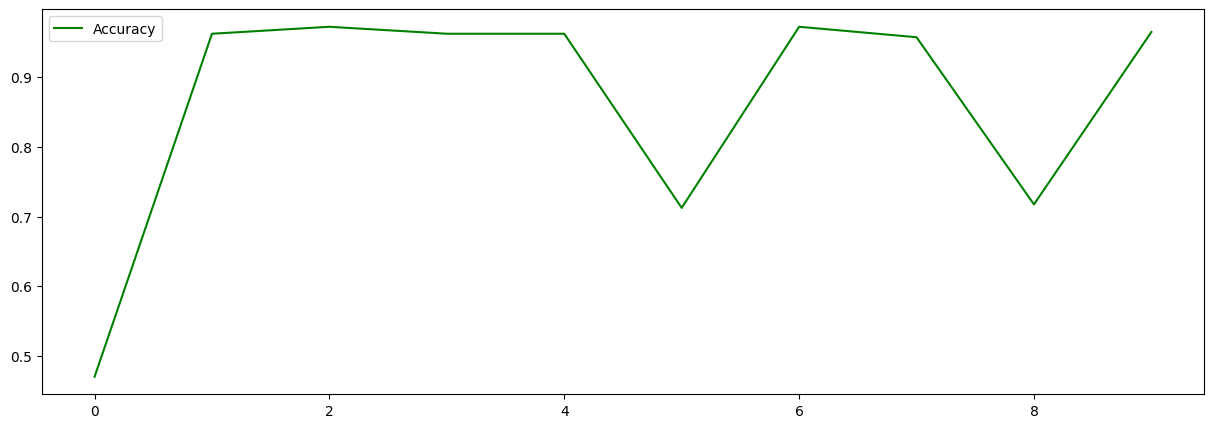

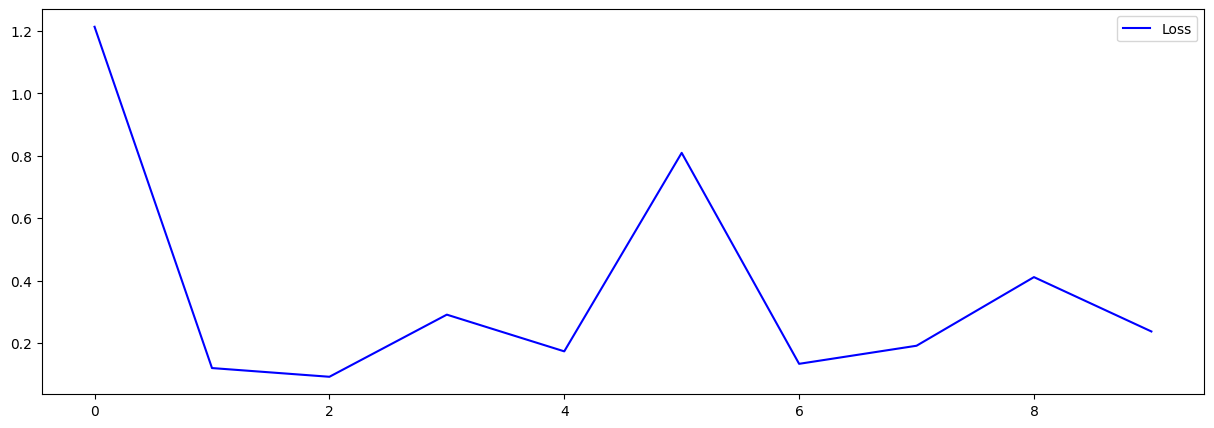

[0.4699999988079071, 0.9624999761581421, 0.9724999666213989, 0.9624999761581421, 0.9624999761581421, 0.7124999761581421, 0.9724999666213989, 0.9574999809265137, 0.7174999713897705, 0.9650000333786011] 
 [1.21371328830719, 0.11992071568965912, 0.0919932872056961, 0.29112303256988525, 0.17348849773406982, 0.8096687197685242, 0.13350743055343628, 0.1914641559123993, 0.41139212250709534, 0.237229585647583]


In [115]:
train_loop(10, 200, 0.005)

Epoch : 1, train accuracy : 0.9432716369628906, train loss : 0.12855805456638336
Epoch : 1, val_accuracy : 0.9158415794372559, val_loss : 0.29928019642829895
Epoch : 2, train accuracy : 0.9670370221138, train loss : 0.09413512796163559
Epoch : 2, val_accuracy : 0.9356435537338257, val_loss : 0.15810582041740417
Epoch : 3, train accuracy : 0.9617283940315247, train loss : 0.09766894578933716
Epoch : 3, val_accuracy : 0.9356435537338257, val_loss : 0.1928734928369522
Epoch : 4, train accuracy : 0.9670370221138, train loss : 0.08670927584171295
Epoch : 4, val_accuracy : 0.9455445408821106, val_loss : 0.1637733429670334
Epoch : 5, train accuracy : 0.9642592072486877, train loss : 0.07948976755142212
Epoch : 5, val_accuracy : 0.9653465151786804, val_loss : 0.15798093378543854
Epoch : 6, train accuracy : 0.9713580012321472, train loss : 0.07473641633987427
Epoch : 6, val_accuracy : 0.9554455280303955, val_loss : 0.1638898253440857
Epoch : 7, train accuracy : 0.970061719417572, train loss : 0

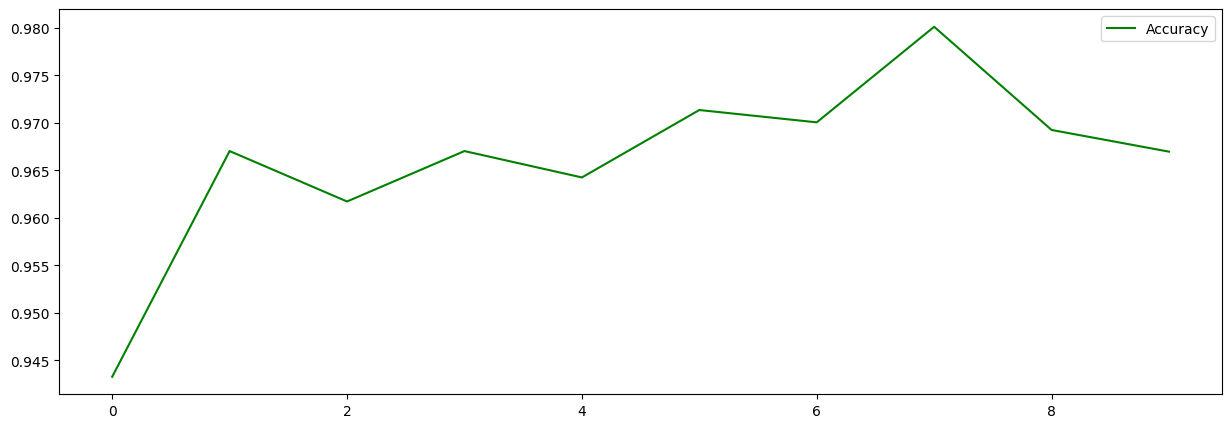

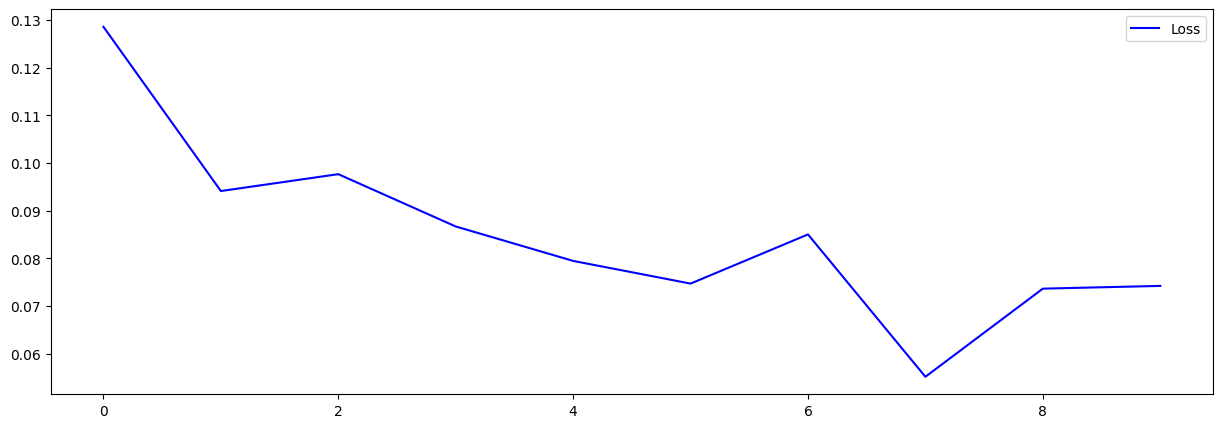

[0.9432716369628906, 0.9670370221138, 0.9617283940315247, 0.9670370221138, 0.9642592072486877, 0.9713580012321472, 0.970061719417572, 0.9801234602928162, 0.9692592620849609, 0.9669752717018127] 
 [0.12855805456638336, 0.09413512796163559, 0.09766894578933716, 0.08670927584171295, 0.07948976755142212, 0.07473641633987427, 0.08504004776477814, 0.055206548422575, 0.07367569953203201, 0.07425038516521454]


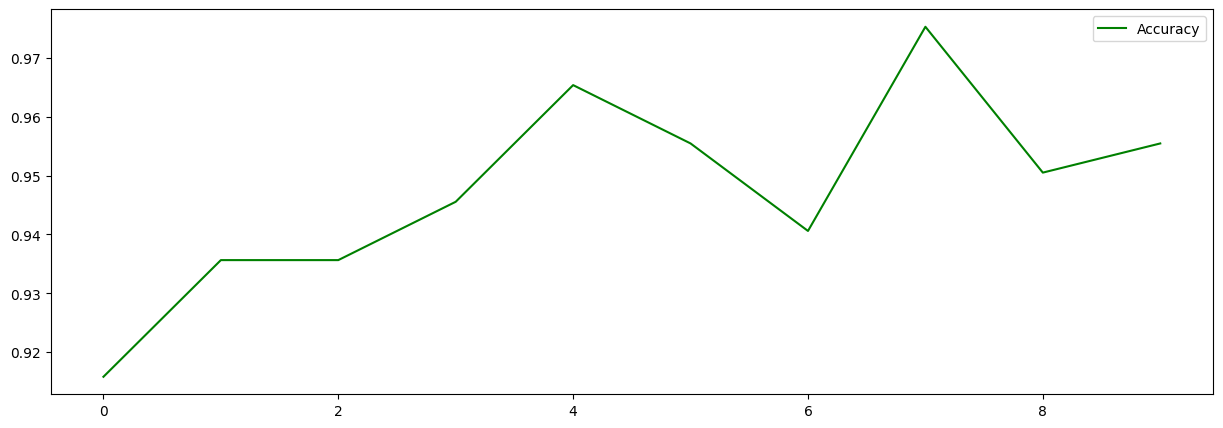

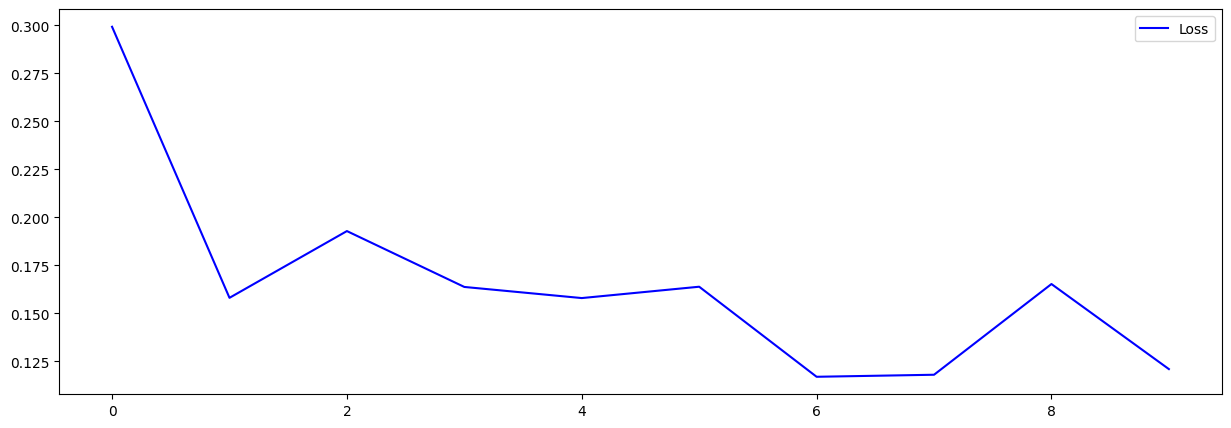

[0.9158415794372559, 0.9356435537338257, 0.9356435537338257, 0.9455445408821106, 0.9653465151786804, 0.9554455280303955, 0.9405940771102905, 0.9752475023269653, 0.9504950642585754, 0.9554455280303955] 
 [0.29928019642829895, 0.15810582041740417, 0.1928734928369522, 0.1637733429670334, 0.15798093378543854, 0.1638898253440857, 0.11698663234710693, 0.11804533749818802, 0.16529414057731628, 0.12098726630210876]


In [116]:
train_loop(10, 300, 0.005)

Epoch : 1, train accuracy : 0.9382352232933044, train loss : 0.153863787651062
Epoch : 1, val_accuracy : 0.9666666984558105, val_loss : 0.1651037633419037
Epoch : 2, train accuracy : 0.9535293579101562, train loss : 0.11531805992126465
Epoch : 2, val_accuracy : 0.9633333683013916, val_loss : 0.18436767160892487
Epoch : 3, train accuracy : 0.9582351446151733, train loss : 0.12059266865253448
Epoch : 3, val_accuracy : 0.9333333969116211, val_loss : 0.162357360124588
Epoch : 4, train accuracy : 0.9497057795524597, train loss : 0.14473387598991394
Epoch : 4, val_accuracy : 0.8066666722297668, val_loss : 0.5039050579071045
Epoch : 5, train accuracy : 0.9479411244392395, train loss : 0.13141238689422607
Epoch : 5, val_accuracy : 0.9600000381469727, val_loss : 0.1776297688484192
Epoch : 6, train accuracy : 0.9479411244392395, train loss : 0.13934168219566345
Epoch : 6, val_accuracy : 0.8999999761581421, val_loss : 0.40380144119262695
Epoch : 7, train accuracy : 0.9294116497039795, train loss 

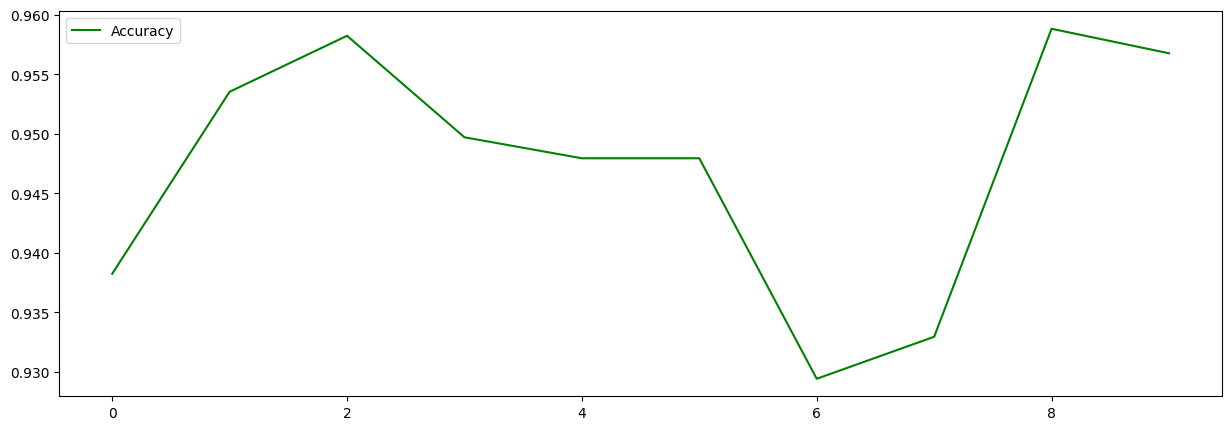

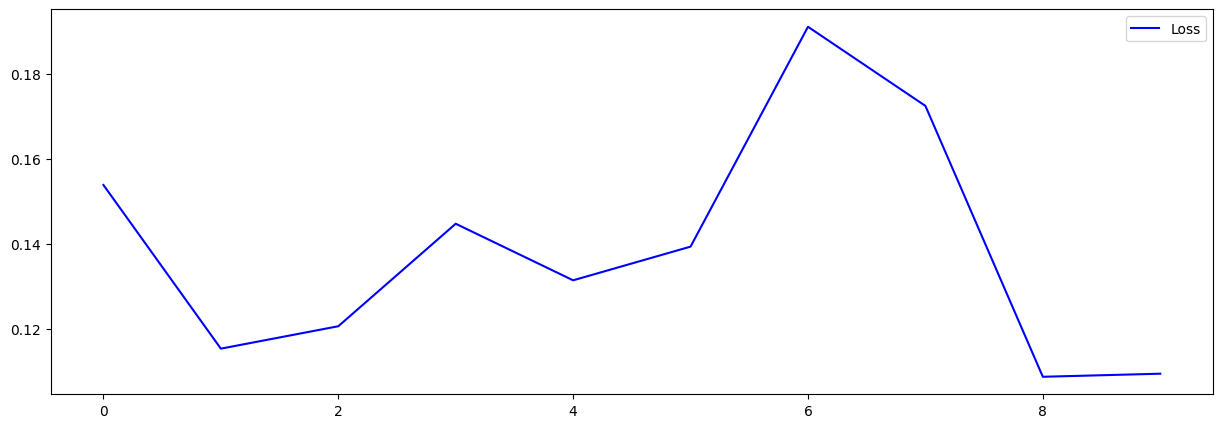

[0.9382352232933044, 0.9535293579101562, 0.9582351446151733, 0.9497057795524597, 0.9479411244392395, 0.9479411244392395, 0.9294116497039795, 0.9329411387443542, 0.9588233828544617, 0.9567645788192749] 
 [0.153863787651062, 0.11531805992126465, 0.12059266865253448, 0.14473387598991394, 0.13141238689422607, 0.13934168219566345, 0.19111691415309906, 0.17248590290546417, 0.10869346559047699, 0.10941702127456665]


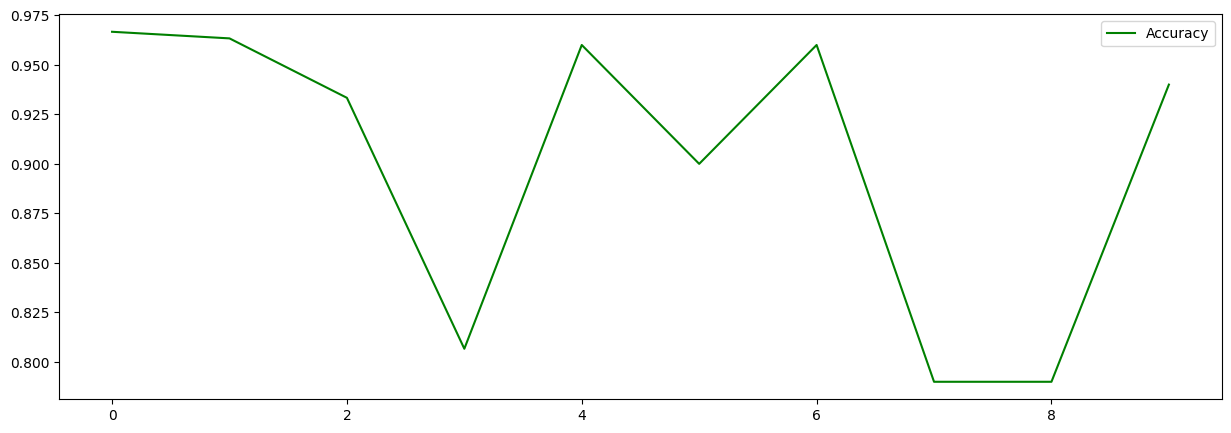

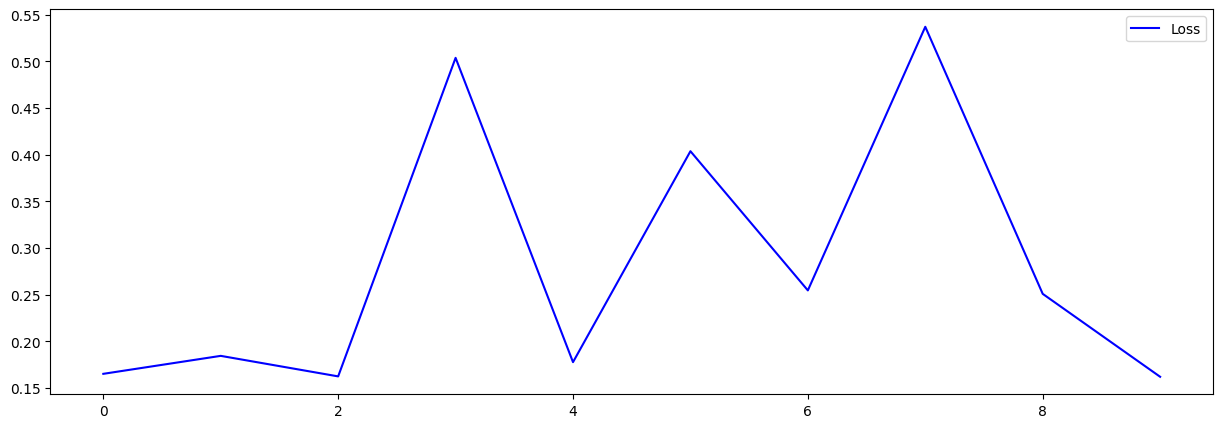

[0.9666666984558105, 0.9633333683013916, 0.9333333969116211, 0.8066666722297668, 0.9600000381469727, 0.8999999761581421, 0.9600000381469727, 0.7900000214576721, 0.7900000214576721, 0.940000057220459] 
 [0.1651037633419037, 0.18436767160892487, 0.162357360124588, 0.5039050579071045, 0.1776297688484192, 0.40380144119262695, 0.2545561194419861, 0.5372174978256226, 0.25086554884910583, 0.16194216907024384]


In [117]:
train_loop(10, 100, 0.007)

Epoch : 1, train accuracy : 0.9616666436195374, train loss : 0.10629869252443314
Epoch : 1, val_accuracy : 0.7300000190734863, val_loss : 0.6169527173042297
Epoch : 2, train accuracy : 0.9549999833106995, train loss : 0.11210291087627411
Epoch : 2, val_accuracy : 0.9700000286102295, val_loss : 0.14888283610343933
Epoch : 3, train accuracy : 0.9572222232818604, train loss : 0.09923114627599716
Epoch : 3, val_accuracy : 0.9800000190734863, val_loss : 0.16072982549667358
Epoch : 4, train accuracy : 0.9594444036483765, train loss : 0.10447739064693451
Epoch : 4, val_accuracy : 0.9600000381469727, val_loss : 0.11894217133522034
Epoch : 5, train accuracy : 0.9505555629730225, train loss : 0.119914710521698
Epoch : 5, val_accuracy : 0.7200000286102295, val_loss : 0.29985353350639343
Epoch : 6, train accuracy : 0.9572222232818604, train loss : 0.10211014002561569
Epoch : 6, val_accuracy : 0.9700000286102295, val_loss : 0.14776523411273956
Epoch : 7, train accuracy : 0.958888828754425, train lo

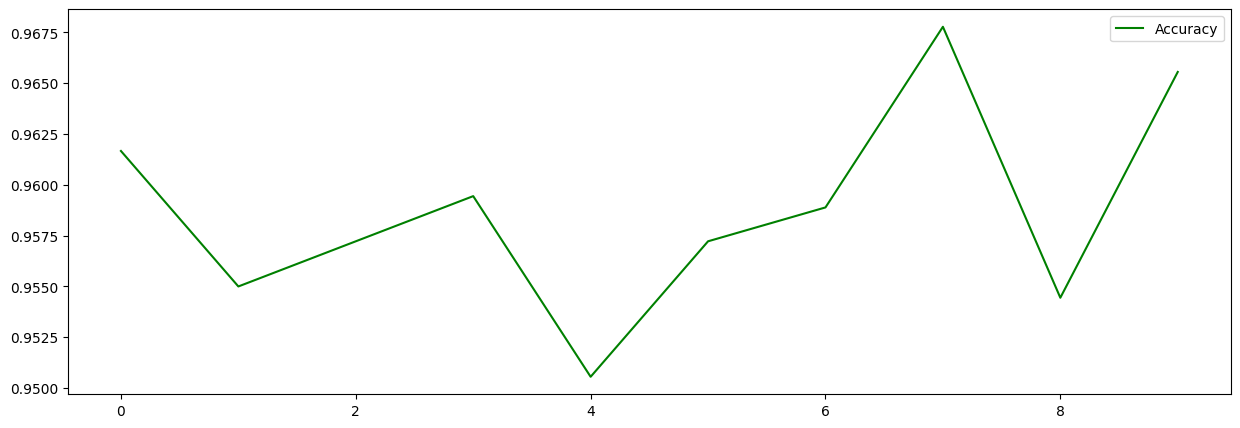

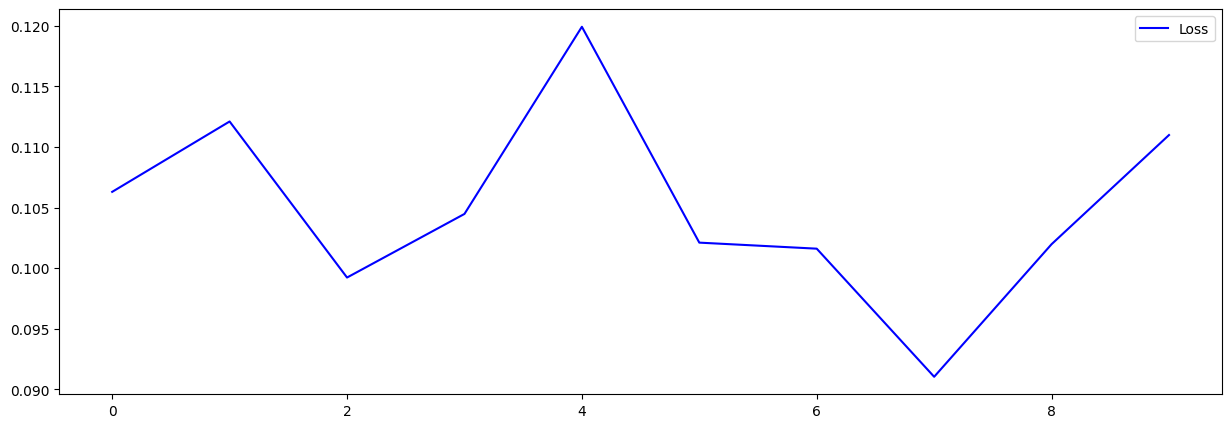

[0.9616666436195374, 0.9549999833106995, 0.9572222232818604, 0.9594444036483765, 0.9505555629730225, 0.9572222232818604, 0.958888828754425, 0.9677778482437134, 0.954444408416748, 0.9655555486679077] 
 [0.10629869252443314, 0.11210291087627411, 0.09923114627599716, 0.10447739064693451, 0.119914710521698, 0.10211014002561569, 0.10161211341619492, 0.09104529768228531, 0.10198147594928741, 0.11098546534776688]


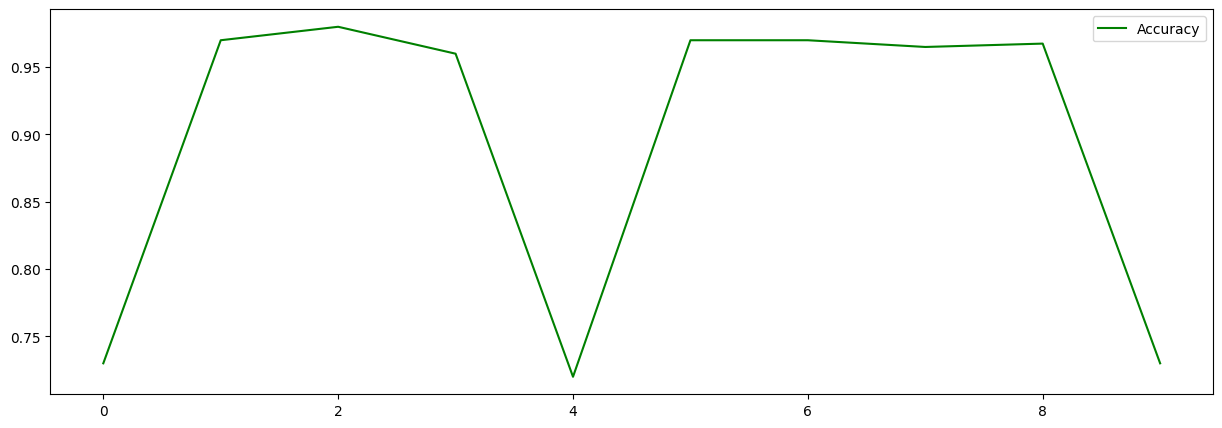

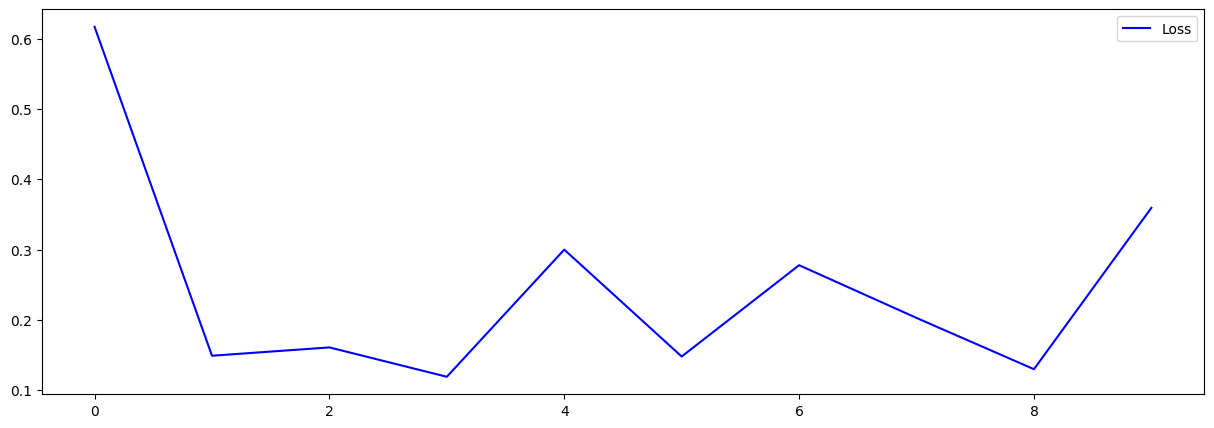

[0.7300000190734863, 0.9700000286102295, 0.9800000190734863, 0.9600000381469727, 0.7200000286102295, 0.9700000286102295, 0.9700000286102295, 0.9650000333786011, 0.9674999713897705, 0.7300000190734863] 
 [0.6169527173042297, 0.14888283610343933, 0.16072982549667358, 0.11894217133522034, 0.29985353350639343, 0.14776523411273956, 0.277709424495697, 0.20267492532730103, 0.12974879145622253, 0.35934072732925415]


In [118]:
train_loop(10, 200, 0.007)

Epoch : 1, train accuracy : 0.9600617289543152, train loss : 0.09501198679208755
Epoch : 1, val_accuracy : 0.9257425665855408, val_loss : 0.21487115323543549
Epoch : 2, train accuracy : 0.9666666984558105, train loss : 0.07730672508478165
Epoch : 2, val_accuracy : 0.9356435537338257, val_loss : 0.2141462117433548
Epoch : 3, train accuracy : 0.9742592573165894, train loss : 0.06821916997432709
Epoch : 3, val_accuracy : 0.9504950642585754, val_loss : 0.12495078891515732
Epoch : 4, train accuracy : 0.9728395342826843, train loss : 0.0711919367313385
Epoch : 4, val_accuracy : 0.9405940771102905, val_loss : 0.19925935566425323
Epoch : 5, train accuracy : 0.9741358160972595, train loss : 0.06618218123912811
Epoch : 5, val_accuracy : 0.9405940771102905, val_loss : 0.16972431540489197
Epoch : 6, train accuracy : 0.9717284440994263, train loss : 0.06807933002710342
Epoch : 6, val_accuracy : 0.9504950642585754, val_loss : 0.13824264705181122
Epoch : 7, train accuracy : 0.974382758140564, train l

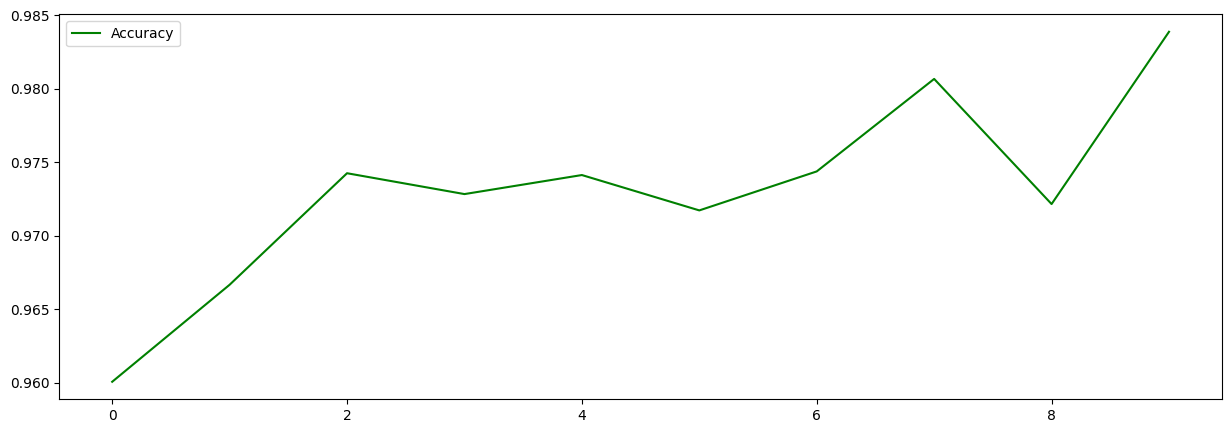

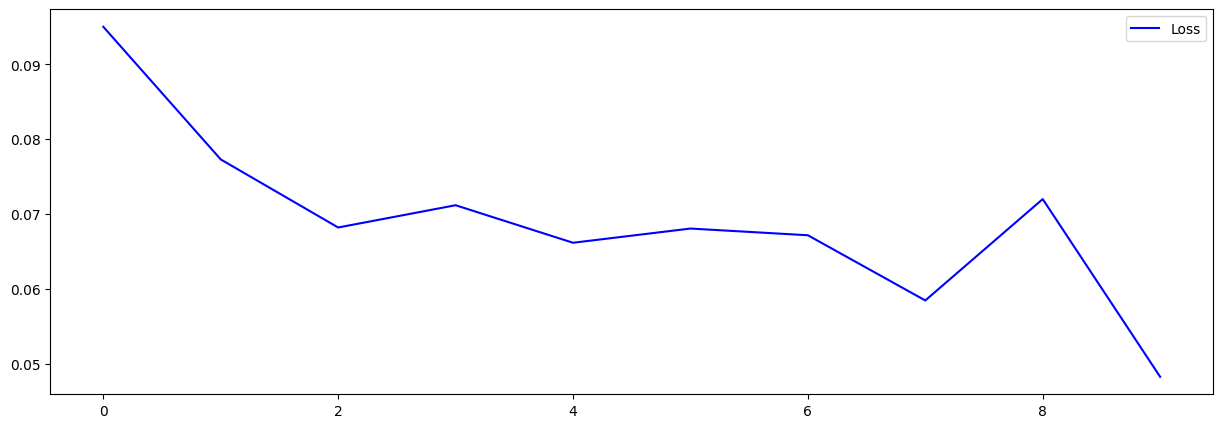

[0.9600617289543152, 0.9666666984558105, 0.9742592573165894, 0.9728395342826843, 0.9741358160972595, 0.9717284440994263, 0.974382758140564, 0.9806790351867676, 0.9721605777740479, 0.9838889241218567] 
 [0.09501198679208755, 0.07730672508478165, 0.06821916997432709, 0.0711919367313385, 0.06618218123912811, 0.06807933002710342, 0.06718391925096512, 0.05848002806305885, 0.07201091945171356, 0.04829314351081848]


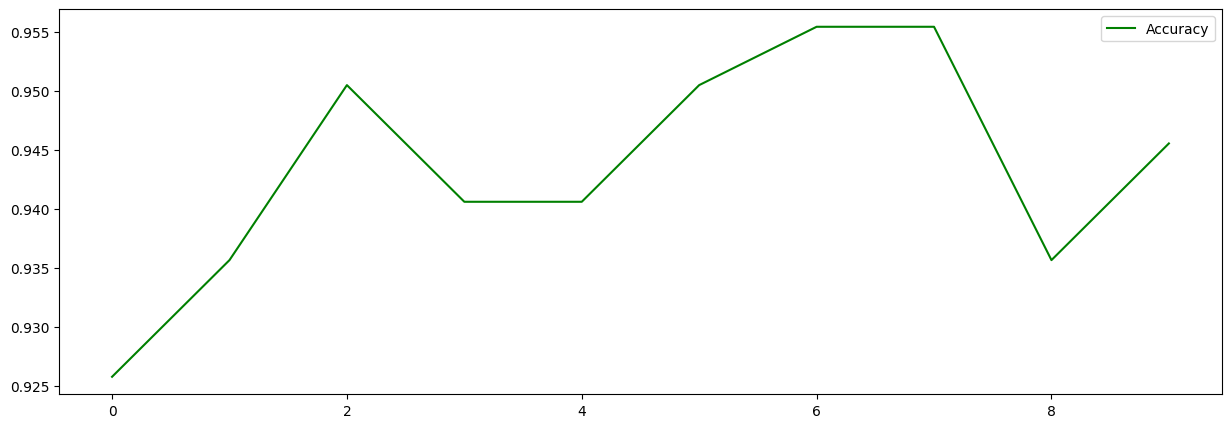

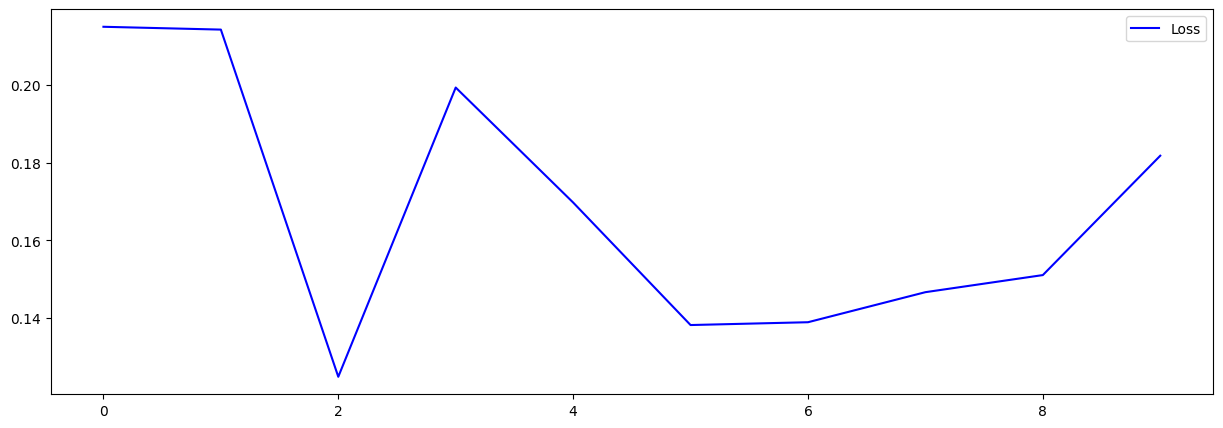

[0.9257425665855408, 0.9356435537338257, 0.9504950642585754, 0.9405940771102905, 0.9405940771102905, 0.9504950642585754, 0.9554455280303955, 0.9554455280303955, 0.9356435537338257, 0.9455445408821106] 
 [0.21487115323543549, 0.2141462117433548, 0.12495078891515732, 0.19925935566425323, 0.16972431540489197, 0.13824264705181122, 0.1389666348695755, 0.14668674767017365, 0.15107756853103638, 0.1817450374364853]


In [119]:
train_loop(10, 300, 0.007)

Создание csv-файл с полученными результатами

In [137]:
rose_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size=100, 
                                          shuffle=False)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(list(fileid), preds_list))
rose_probs.sort(key = lambda x : int(x[0]))
rose_probs[:10]

[(tensor(0), 3.498870137264021e-05),
 (tensor(0), 2.0185421817586757e-05),
 (tensor(0), 0.007598156575113535),
 (tensor(0), 5.349245111574419e-05),
 (tensor(0), 0.011648613028228283),
 (tensor(0), 0.00022119925415609032),
 (tensor(0), 0.00025334517704322934),
 (tensor(0), 0.07412093877792358),
 (tensor(0), 0.03588611260056496),
 (tensor(0), 1.0439793186378665e-05)]

In [138]:
idx = list(i for i in range(len(rose_probs)))
prob = list(map(lambda x: x[1],rose_probs))

In [139]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,0.000035
1,1,0.000020
2,2,0.007598
3,3,0.000053
4,4,0.011649
...,...,...
196,196,0.999732
197,197,0.973102
198,198,0.999962
199,199,0.999230


сохранение модели

In [140]:
torch.save(model.state_dict(), os.path.join("D:\Lab on python\Lab_1_var_4\Lab5", "weight.pt"))

повторная инициализация модели

In [141]:
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("D:\Lab on python\Lab_1_var_4\Lab5", "weight.pt")))

<All keys matched successfully>

Запуск модели на тренировочных данных

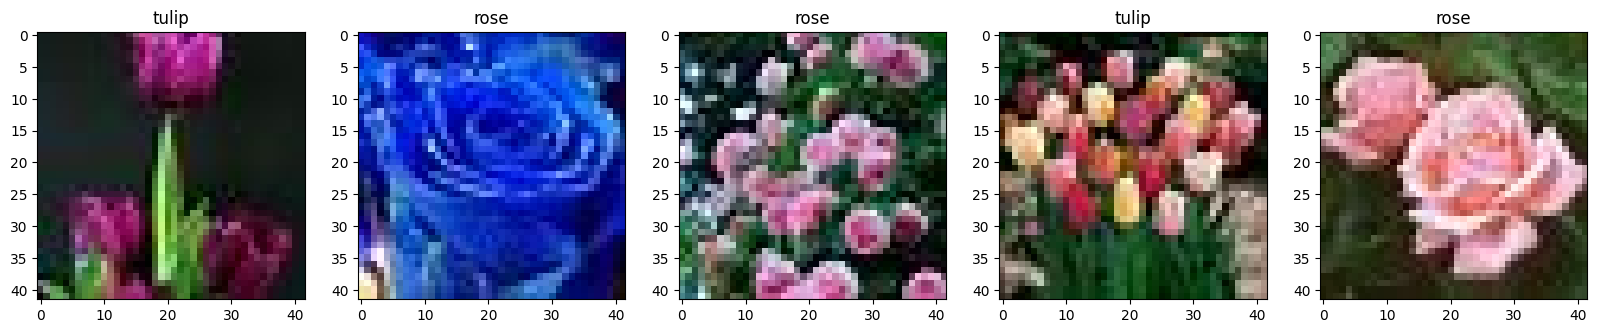

In [157]:
id_list = []
class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)